In [49]:
# https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb

import sys
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import pytorch_lightning as pl
import timm
import torchmetrics
from PIL import Image
from scipy import ndimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
from torch.nn.functional import cross_entropy
from torchmetrics.functional import accuracy
from optuna_integration import PyTorchLightningPruningCallback

%matplotlib inline
np.random.seed(1)

In [50]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [51]:
import dl_utils

In [52]:
# Loading the data (signs)
def get_imgs_labels(h5_file_path):
    f = h5py.File(h5_file_path, "r")
    ds_keys = [key for key in f.keys()]
    imgs = np.array(f[ds_keys[1]])    
    labels = np.array(f[ds_keys[2]])
    list_classes = np.array(f[ds_keys[0]])
    imgs = np.transpose(imgs, (0, 3, 1, 2))
    return imgs, labels, list_classes

train_x, train_y, train_classes = get_imgs_labels("./datasets/train_signs.h5")
test_x, test_y, test_classes = get_imgs_labels("./datasets/test_signs.h5")
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(1080, 3, 64, 64) (1080,)
(120, 3, 64, 64) (120,)


In [53]:
# CONSTANTS
class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"

class Config:
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    NUM_CLASSES = 6
    BATCH_SIZE = 64
    NUM_WORKERS = 4
    NUM_EPOCHS = 30
    TRAIN_IMG_MEAN = [0.485, 0.456, 0.406]
    TRAIN_IMG_STD = [0.229, 0.224, 0.225]
    UNFREEZE_EPOCH_NO = 2
    PRECISION = "16-mixed"
    PATIENCE = 6
    LOG_EVERY_N_STEPS = 10
    MODEL_TO_USE = Models.RESNET50
    WEIGHT_DECAY = 1e-6
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 0.005,
        "warmup_prop": 0.05
    }

class SchedulerConfig:
    SCHEDULER_PATIENCE = 3
    SCHEDULER = "ReduceLROnPlateau"
    T_0 = 10 # for CosineAnnealingWarmRestarts
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts
    MAX_LR = 1e-2
    STEPS_PER_EPOCH = 13 # for OneCycleLR

class WandbConfig:
    WANDB_KEY = ""
    WANDB_RUN_NAME = "pl_cnn_signs_resnet50"
    WANDB_PROJECT = "pl_cnn_signs"
    USE_WANDB = True    


In [54]:
def config_to_dict(cfg):
    # dir is an inbuilt python function that returns the list of attributes and methods of any object
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [55]:
config_dict = config_to_dict(Config)
schd_config_dict = config_to_dict(SchedulerConfig)
merged_config_dict = {**config_dict, **schd_config_dict}

In [56]:
# for a training and label data in form of numpy arrays, return a fold_index array whose elements
# represent the fold index. The length of this fold_index array is same as length of input dataset
# and the items for which fold_index array value == cv iteration count are to be used for validation 
# in the corresponding cross validation iteration with rest of the items ( for which fold_index 
# array value != cv iteration count ) being used for training (typical ration being 80:20)
def get_skf_index(num_folds, X, y):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = 42)
    train_fold_index = np.zeros(len(y))
    for fold, (train_index, val_index) in enumerate(skf.split(X=X, y=y)):
        train_fold_index[val_index] = [fold + 1] * len(val_index)
    return train_fold_index

k_folds = get_skf_index(num_folds=Config.NUM_FOLDS, X=train_x, y=train_y)

In [57]:
class NpArrayImageDataset(Dataset):
    def __init__(self, img_arr, label_arr, transform, target_transform, 
                transform_type=TransformationType.TORCHVISION):
        self.img_arr = img_arr
        self.label_arr = label_arr
        self.transform = transform
        self.target_transform = target_transform
        self.transform_type = transform_type

    def __len__(self):
        return len(self.label_arr)

    def __getitem__(self, index):
        tfmd_img = self.img_arr[index]
        tfmd_img = tfmd_img.transpose(1,2,0)
        #print(type(tfmd_img), tfmd_img.shape)
        tfmd_label = self.label_arr[index]
        if self.transform:
            if self.transform_type == TransformationType.TORCHVISION:                        
                tfmd_img = self.transform(tfmd_img)
            elif self.transform_type == TransformationType.ALB:
                augmented = self.transform(image=tfmd_img)
                tfmd_img = augmented["image"]                   
        if self.target_transform:               
            tfmd_label = self.target_transform(tfmd_label)              
        return tfmd_img, tfmd_label            

In [58]:
img_transforms = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize(Config.TRAIN_IMG_MEAN, Config.TRAIN_IMG_STD)])

# Get the train and validation data loaders for a specific fold. 
# X: numpy array of input features
# y: numpy array of target labels
# fold: fold index for which to create data loaders                                     
# kfolds: Array that marks each of the data items as belonging to a specific fold
def get_fold_dls(fold, kfolds, X, y):
    fold += 1                         
    train_X = X[kfolds != fold]        
    train_y = y[kfolds != fold]    
    val_X = X[kfolds == fold]
    val_y = y[kfolds == fold]
    ds_train = NpArrayImageDataset(train_X, train_y, transform=img_transforms, target_transform=torch.as_tensor)
    ds_val = NpArrayImageDataset(val_X, val_y, transform=img_transforms, target_transform=torch.as_tensor)
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [59]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(9, 6))
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]            
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(Image.fromarray(np.uint8(img)).convert('RGB'))        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

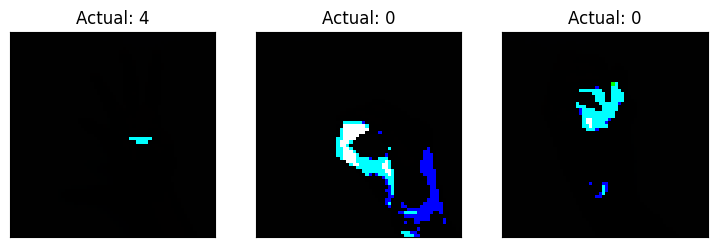

In [60]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)
#len(ds_val)
show_batch(ds_val, 3, 1, 3)

In [61]:
class ImageClassificationLitModel(pl.LightningModule):
    def __init__(self, config_dict):
        super().__init__()
        self.save_hyperparameters()
        self.config_dict = config_dict                
        self.num_classes = config_dict["NUM_CLASSES"]
        self.lr = config_dict["MODEL_PARAMS"]["lr"]
        self.backbone, self.classifier = self.get_backbone_classifier(
            config_dict["MODEL_TO_USE"],
            config_dict["MODEL_PARAMS"]["drop_out"], 
            self.num_classes
        ) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=True)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):        
        params = self.parameters()
        print(f"len(params) = {len(list(params))}")
        return dl_utils.get_optimizer(lr=self.lr, params=self.parameters(), config_dict=self.config_dict)    
    
    # def configure_optimizers(self):
    #     model_optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=Config.WEIGHT_DECAY)
    #     print(f"param groups count = {len(model_optimizer.param_groups)}")
    #     lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, "min", patience=SchedulerConfig.SCHEDULER_PATIENCE)        
    #     return {
    #         "optimizer": model_optimizer, 
    #         "lr_scheduler": {
    #             "scheduler": lr_scheduler,
    #             "monitor": "val_loss",
    #             "frequency": 1
    #         }
    #     }

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        acc = accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        val_acc = accuracy(y_pred, y, task="multiclass", num_classes=self.num_classes)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_acc", val_acc, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("cur_lr", current_lr, prog_bar=True, on_step=True, on_epoch=True, logger=True)
        return {"loss": val_loss, "val_acc": val_acc}

In [62]:
# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(Config.RANDOM_SEED, workers=True)

Seed set to 42


42

In [63]:
class OptunaPruning(PyTorchLightningPruningCallback, pl.Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [64]:
def run_hparam_tuning(model_params, trial):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, k_folds, train_x, train_y)    
    early_stopping = OptunaPruning(trial, monitor="val_loss")
    multiplicative = lambda epoch: 1.5
    backbone_finetuning_cb = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=False)
    signs_model = ImageClassificationLitModel(config_dict=merged_config_dict)  
    trainer = pl.Trainer(
        devices="auto",
        accelerator="gpu",
        # For results reproducibility 
        deterministic=True,
        strategy="auto",
        log_every_n_steps=Config.LOG_EVERY_N_STEPS,
        max_epochs=Config.NUM_EPOCHS,        
        precision=Config.PRECISION,   
        enable_model_summary=True,
        enable_progress_bar=True,
        callbacks=[backbone_finetuning_cb, early_stopping]
    )      
    trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)     
    loss = trainer.callback_metrics["val_loss"].item()
    del trainer, signs_model, early_stopping, backbone_finetuning_cb, dl_train, dl_val
    return loss

In [65]:
# import optuna

# def objective(trial):
#     params = {
#         "lr": trial.suggest_float("lr", low=1e-6, high=1e-3, log=True),
#         "drop_out": trial.suggest_float("drop_out", low=0.2, high=0.7)
#     }    
#     loss = run_hparam_tuning(params, trial)
#     return loss

# study = optuna.create_study(direction="minimize", study_name="SignsImageClassificationTuning")    
# study.optimize(objective, n_trials=10)
# print(f"Best trial number = {study.best_trial.number}")
# print("Best trial params:")
# print(study.best_params)

In [66]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

class MetricsAggCallback(Callback):
    def __init__(self, metric_to_monitor, mode):
        self.metric_to_monitor = metric_to_monitor
        self.metrics = []
        self.best_metric = None
        self.mode = mode
        self.best_metric_epoch = None
        self.val_epoch_num = 0
    
    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        self.val_epoch_num += 1
        metric_value = trainer.callback_metrics[self.metric_to_monitor].cpu().detach().item()
        val_loss = trainer.callback_metrics["val_loss"].cpu().detach().item()
        current_lr = trainer.callback_metrics["cur_lr"].cpu().detach().item()
        print(f"epoch = {self.val_epoch_num} => metric {self.metric_to_monitor} = {metric_value}, " \
              f"val_loss={val_loss}, lr={current_lr}")
        self.metrics.append(metric_value)
        if self.mode == "max":
            self.best_metric = max(self.metrics)
            self.best_metric_epoch = self.metrics.index(self.best_metric)                

In [67]:
import wandb
from pytorch_lightning.loggers import WandbLogger

def get_wandb_logger(fold, config_dict=None):
    logger = None
    if WandbConfig.USE_WANDB:        
        wandb.login(key=WandbConfig.WANDB_KEY)        
        logger = WandbLogger(
            name=WandbConfig.WANDB_RUN_NAME + f"_fold{fold}", 
            project=WandbConfig.WANDB_PROJECT,
            config=config_dict,
            group=Config.MODEL_TO_USE
        )
    return logger

In [68]:
import gc
from lightning.pytorch.tuner import Tuner

def run_training(fold, dl_train, dl_val, find_lr=True):
    try:
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")        
        logger = get_wandb_logger(fold, merged_config_dict)
        print("Instantiated wandb logger")    
        chkpt_file_name = "best_model_{epoch}_{val_loss:.4f}"        
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)
        if fold is not None:       
            chkpt_file_name = fold_str + "_" + chkpt_file_name
        signs_model = ImageClassificationLitModel(config_dict=merged_config_dict)    
        loss_chkpt_callback = ModelCheckpoint(dirpath="./model", verbose=True, monitor="val_loss", mode="min", filename=chkpt_file_name)
        acc_chkpt_callback = MetricsAggCallback(metric_to_monitor="val_acc", mode="max")
        trainer = pl.Trainer(
            devices="auto",
            accelerator="gpu",
            # For results reproducibility 
            deterministic=True,
            strategy="auto",
            log_every_n_steps=Config.LOG_EVERY_N_STEPS,
            max_epochs=Config.NUM_EPOCHS,        
            precision=Config.PRECISION,   
            enable_model_summary=True,
            enable_progress_bar=True,                        
            logger=logger,            
            callbacks=[loss_chkpt_callback, acc_chkpt_callback, backbone_finetuning, early_stopping_callback]
        )
        tuner = Tuner(trainer)
        
        if find_lr:
            lr_finder = tuner.lr_find(model=signs_model, train_dataloaders=dl_train)
            # Results can be found in
            print(lr_finder.results)
            # Results can be plotted to identify the optimal learning rate
            fig = lr_finder.plot(suggest=True)
            fig.show()
            # Pick the suggested learning rate
            new_lr = lr_finder.suggestion()
            print(f"new_lr = {new_lr}")

        trainer.fit(signs_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        loss = loss_chkpt_callback.best_model_score.cpu().detach().item()
        acc = acc_chkpt_callback.best_metric
        print(f"Loss for {fold_str} = {loss}, accuracy = {acc}")
        del trainer, tuner, signs_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, loss_chkpt_callback                 
        return loss, acc
    except KeyboardInterrupt as e:
        wandb.finish(exit_code=-1, quiet=True)
        print("Marked the wandb run as failed")
    finally:
        gc.collect()
        torch.cuda.empty_cache()
        wandb.finish()

In [69]:
find_lr = True
fold_loss = []
fold_acc = []

for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, k_folds, train_x, train_y)
    loss, acc = run_training(fold, dl_train, dl_val, find_lr=False)
    fold_loss.append(loss)
    fold_acc.append(acc)
    break
     

Running training for fold0


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bkanupam. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/bk_anupam/.netrc


Instantiated wandb logger


Using 16bit Automatic Mixed Precision (AMP)
/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_lightning/plugins/precision/amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | backbone   | Sequential | 23.5 M | train
1 | classifier | Sequential | 12.3 K | train
--------------------------------------------------
65.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.081    Total estimated model params size (MB)


len(params) = 161
param groups count = 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

epoch = 1 => metric val_acc = 0.1640625, val_loss=1.8243789672851562, lr=0.004999999888241291


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.104
Epoch 0, global step 14: 'val_loss' reached 1.10354 (best 1.10354), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=0_val_loss=1.1035.ckpt' as top 1


epoch = 2 => metric val_acc = 0.5694444179534912, val_loss=1.1035401821136475, lr=0.004999999422580004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.422 >= min_delta = 0.0. New best score: 0.681
Epoch 1, global step 28: 'val_loss' reached 0.68118 (best 0.68118), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=1_val_loss=0.6812.ckpt' as top 1


epoch = 3 => metric val_acc = 0.7685185074806213, val_loss=0.6811829209327698, lr=0.004999999422580004


/home/bk_anupam/anaconda3/envs/ml_env/lib/python3.11/site-packages/pytorch_lightning/callbacks/finetuning.py:238: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
Current lr: 0.005, Backbone lr: 0.0005


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 42: 'val_loss' was not in top 1
Current lr: 0.005, Backbone lr: 0.00075


epoch = 4 => metric val_acc = 0.26851850748062134, val_loss=2.3487935066223145, lr=0.004999999422580004


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.404 >= min_delta = 0.0. New best score: 0.277
Epoch 3, global step 56: 'val_loss' reached 0.27672 (best 0.27672), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=3_val_loss=0.2767.ckpt' as top 1


epoch = 5 => metric val_acc = 0.8888888955116272, val_loss=0.2767183184623718, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.155 >= min_delta = 0.0. New best score: 0.122
Epoch 4, global step 70: 'val_loss' reached 0.12176 (best 0.12176), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=4_val_loss=0.1218.ckpt' as top 1


epoch = 6 => metric val_acc = 0.9722222089767456, val_loss=0.12175639718770981, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.115
Epoch 5, global step 84: 'val_loss' reached 0.11474 (best 0.11474), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=5_val_loss=0.1147.ckpt' as top 1


epoch = 7 => metric val_acc = 0.9722222089767456, val_loss=0.11473800241947174, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.113
Epoch 6, global step 98: 'val_loss' reached 0.11330 (best 0.11330), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=6_val_loss=0.1133.ckpt' as top 1


epoch = 8 => metric val_acc = 0.9768518805503845, val_loss=0.11329903453588486, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.112
Epoch 7, global step 112: 'val_loss' reached 0.11170 (best 0.11170), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=7_val_loss=0.1117.ckpt' as top 1


epoch = 9 => metric val_acc = 0.9768518805503845, val_loss=0.11169567704200745, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.107
Epoch 8, global step 126: 'val_loss' reached 0.10743 (best 0.10743), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=8_val_loss=0.1074.ckpt' as top 1


epoch = 10 => metric val_acc = 0.9722222089767456, val_loss=0.1074310764670372, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 140: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 11 => metric val_acc = 0.9722222089767456, val_loss=0.11418222635984421, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 154: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 12 => metric val_acc = 0.9675925970077515, val_loss=0.11910085380077362, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 168: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 13 => metric val_acc = 0.9675925970077515, val_loss=0.10768663138151169, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.096
Epoch 12, global step 182: 'val_loss' reached 0.09604 (best 0.09604), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=12_val_loss=0.0960.ckpt' as top 1


epoch = 14 => metric val_acc = 0.9722222089767456, val_loss=0.09604063630104065, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.086
Epoch 13, global step 196: 'val_loss' reached 0.08621 (best 0.08621), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=13_val_loss=0.0862.ckpt' as top 1


epoch = 15 => metric val_acc = 0.9768518805503845, val_loss=0.08620984107255936, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.082
Epoch 14, global step 210: 'val_loss' reached 0.08237 (best 0.08237), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=14_val_loss=0.0824.ckpt' as top 1


epoch = 16 => metric val_acc = 0.9814814925193787, val_loss=0.08237394690513611, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 224: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 17 => metric val_acc = 0.9768518805503845, val_loss=0.08452874422073364, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.082
Epoch 16, global step 238: 'val_loss' reached 0.08227 (best 0.08227), saving model to '/home/bk_anupam/code/ML/DeepLearningWSL/ComputerVision/CNN/model/fold0_best_model_epoch=16_val_loss=0.0823-v1.ckpt' as top 1


epoch = 18 => metric val_acc = 0.9768518805503845, val_loss=0.08226781338453293, lr=0.000750000006519258


Current lr: 0.00075, Backbone lr: 0.00075


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 252: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 19 => metric val_acc = 0.9768518805503845, val_loss=0.0873212218284607, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 266: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 20 => metric val_acc = 0.9768518805503845, val_loss=0.09113413095474243, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 280: 'val_loss' was not in top 1
Current lr: 0.00075, Backbone lr: 0.00075


epoch = 21 => metric val_acc = 0.9768518805503845, val_loss=0.08655253052711487, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 294: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 22 => metric val_acc = 0.9768518805503845, val_loss=0.09025446325540543, lr=0.000750000006519258


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 308: 'val_loss' was not in top 1
Current lr: 7.5e-05, Backbone lr: 7.5e-05


epoch = 23 => metric val_acc = 0.9768518805503845, val_loss=0.0894472524523735, lr=7.500000356230885e-05


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 6 records. Best score: 0.082. Signaling Trainer to stop.
Epoch 22, global step 322: 'val_loss' was not in top 1


epoch = 24 => metric val_acc = 0.9814814925193787, val_loss=0.09083932638168335, lr=7.500000356230885e-05
Loss for fold0 = 0.08226781338453293, accuracy = 0.9814814925193787


cur_lr_epoch,███▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
cur_lr_step,██████▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_acc_epoch,▁▅▆▇███████████████████
train_acc_step,▁▅▆▇████████████████████████████
train_loss_epoch,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▅▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▁▂▁▁▃▁▃▂▃▃▂▄▂▄▂▄▅▂▅▂▅▂▂▆▂▆▃▇▃▃▇▃█▃██
val_acc_epoch,▄▆▁▇███████████████████
val_acc_step,▃▅▆▆▂▁▇█████████████████████████████████
val_loss_epoch,▄▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [70]:
import statistics

print("Loss across folds")
print(fold_loss)
print("Accuracy across folds")
print(fold_acc)

if len(fold_loss) > 1:
    mean_loss = statistics.mean(fold_loss)
    mean_acc = statistics.mean(fold_acc)
    std_loss = statistics.stdev(fold_loss)
    std_acc = statistics.stddev(fold_acc)
    print(f"mean loss across folds = {mean_loss}, loss stdev across fold = {std_loss}")
    print(f"mean accuracy across folds = {mean_acc}, accuracy stdev across fold = {std_acc}")

Loss across folds
[0.08226781338453293]
Accuracy across folds
[0.9814814925193787]


In [71]:
# import tqdm

# model = ImageClassificationLitModel.load_from_checkpoint(
#     checkpoint_path="model/fold0_best_model_epoch=8_val_loss=0.0853-v1.ckpt",     
#     num_classes=Config.NUM_CLASSES
#     )
# model.to("cuda")
# model.eval()

# incorrect = 0
# total = 0
# predicted_labels_incorrect = []
# labels_incorrect = []
# with torch.no_grad():
#     counter=0
#     for imgs, labels in tqdm.tqdm(dl_val):                
#         predicted_cuda_labels = torch.argmax(model(imgs.to("cuda")), dim=1)
#         predicted_labels = predicted_cuda_labels.cpu().detach()
#         total += labels.shape[0]
#         correct_pred = predicted_labels == labels
#         incorrect_pred = ~correct_pred
#         num_incorrect_pred = incorrect_pred.sum()
#         incorrect += int(num_incorrect_pred)
#         if num_incorrect_pred > 0:
#             predicted_labels_incorrect.append(predicted_labels[incorrect_pred].numpy())
#             labels_incorrect.append(labels[incorrect_pred].numpy())
# print(f'Total no. of images in validation set: {total}')
# print(f'Incorrectly classified images in validation set: {incorrect}')
# accuracy = ((total-incorrect) / total) * 100        
# print(f"Accuracy: {accuracy}%")